In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

#                                         Dataset 1a:

### Importing the train, test and cross validation data sets

In [2]:
col_names=["x1","x2","y"]

In [3]:
## Train data
data1a=pd.read_csv("train.csv",names=col_names)

In [4]:
data1a.head()

,x1,x2,y
0,-7.811425,1.910665,1.0
1,-0.856640,-9.639107,3.0
2,2.885077,4.785598,0.0
3,-1.405758,-7.364262,3.0
4,0.044472,-8.998423,3.0


In [5]:
## Splitting the columns of train data

X1train=data1a["x1"]
X2train=data1a["x2"]
Ytrain=np.array(data1a["y"])
Xtrain=np.array(data1a.drop("y",axis=1))

In [6]:
## group labels 
data1a["y"].unique()

array([1., 3., 0., 2.])

In [7]:
## Importing the test and cross-validation data
data1a_dev=pd.read_csv("dev.csv",names=col_names)

In [8]:
## Function to split a given dataset into test and cross-validation

def create_datasets(data,cv_size):
    data.sample(frac=1).reset_index(drop=True)
    data_cv=data[0:cv_size]
    data_test=data[cv_size:]
    return(data_cv,data_test)

In [9]:
def euclidean(p1,p2):
    d=np.linalg.norm(np.array(p1)-np.array(p2))
    return d

In [10]:
def accuracy(y_pred,y_actual):
    true_count=0
    for i in range(len(y_pred)):
        if y_pred[i]==y_actual[i]:
            true_count+=1;
    return(true_count/len(y_pred))

In [11]:
data1a_dev.shape

(120, 3)

In [12]:
## Splitting in the ratio 70:30 (cv:test)
data1a_cv,data1a_test=create_datasets(data1a_dev,84)

### Plotting the train data set

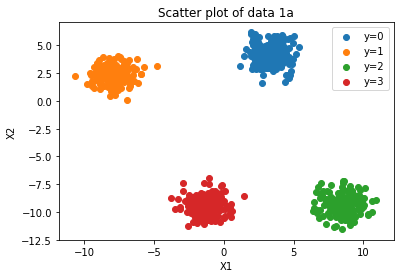

In [13]:
X_cv=np.array(data1a_cv.drop("y",axis=1))
Y_cv=np.array(data1a_cv["y"])
X_test=np.array(data1a_test.drop("y",axis=1))
Y_test=np.array(data1a_test["y"])

plt.figure()
plt.scatter(X1train[Ytrain==0],X2train[Ytrain==0],label="y=0")
plt.scatter(X1train[Ytrain==1],X2train[Ytrain==1],label="y=1")
plt.scatter(X1train[Ytrain==2],X2train[Ytrain==2],label="y=2")
plt.scatter(X1train[Ytrain==3],X2train[Ytrain==3],label="y=3")
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Scatter plot of data 1a")
plt.savefig("Scatter plot of data_1a.jpg")
plt.show()

# K Nearest Neighbour Classifier for dataset 1a:

In [14]:
def knn(x,y,test,k):
    distances=[]
    for i in range(len(x)):
        d=euclidean(x[i],test)
        l=(d,x[i],y[i])
        distances.append(l)
    distances.sort(key = lambda x:x[0])
    count=Counter()
    for i in distances[:k]:
        count[i[2]]+=1
    pred=count.most_common(1)[0][0]
    return(distances[:k],pred)
    

### KNN on given cross-validation and test datasets:

In [15]:
k_list=[1,7,15]
Accuracy_cv=[]
Accuracy_train=[]
Accuracy_test=[]

In [17]:
## iterating over k-values
for i in k_list:
    ycv_pred=[]
    for j in X_cv:
        ycv_pred.append(knn(Xtrain,Ytrain,j,i)[1])
    ytest_pred=[]
    for j in X_test:
        ytest_pred.append(knn(Xtrain,Ytrain,j,i)[1])
    ytrain_pred=[]
    for j in Xtrain:
        ytrain_pred.append(knn(Xtrain,Ytrain,j,i)[1])
    Accuracy_cv.append(accuracy(Y_cv,ycv_pred))
    Accuracy_test.append(accuracy(Y_test,ytest_pred))
    Accuracy_train.append(accuracy(Ytrain,ytrain_pred))

In [18]:
accuracy_table_knn=pd.DataFrame(list(zip(k_list,Accuracy_train,Accuracy_cv,Accuracy_test)),columns=["k-value", "Accuracy train","Accuracy CV","Accuracy test"])

In [19]:
accuracy_table_knn

,k-value,Accuracy train,Accuracy CV,Accuracy test
0,1,1.0,1.0,1.0
1,7,1.0,1.0,1.0
2,15,1.0,1.0,1.0


In [35]:
np.linalg.inv(np.cov(Xtrain,rowvar=False))

array([[0.03181672, 0.01238728],
       [0.01238728, 0.02910215]])

# Naive Bayes Classifier:

In [36]:
def seperate_by_classval(data):
    ## the target variable must be stored in a column named "y"
    class_vals=list(data["y"].unique())
    seperated=dict()
    features=data.drop('y',axis=1)
    Y=np.array(data["y"])
    ## creates a key value corresponding to each class label
    for i in class_vals:
        seperated[i]=features[Y==i];
    return(seperated)

In [103]:
def priori(data):
    seperated_data=seperate_by_classval(data)
    probs=dict()
    for i in seperated_data.keys():
        probs[i]=len(seperated_data[i])/len(data);
    return probs

In [37]:
def mu_sigma(data):
    seperated_data=seperate_by_classval(data)
    mean=dict()
    sigma={}
    for i in list(seperated_data.keys()):
        features=seperated_data[i]
        mean[i]=[]
        sigma[i]=[]
        for j in range(seperated_data[i].shape[1]):
            mean[i].append(np.mean(features.iloc[:,j]))
            sigma[i].append(np.std(features.iloc[:,j]))
    return(mean,sigma)  

In [117]:
def gauss_val(x,cov_matrix,mean):
    x=np.array(x)
    A=(x-mean)
    B=np.linalg.inv(cov_matrix)
    C=np.transpose(A)
    det=np.linalg.det(cov_matrix)
    AB=A.dot(B)
    m=AB.dot(C)
    
    exp_term=np.exp(-m/2)
    d=2
    return (exp_term/(2*np.pi*det**0.5))

## Seperating the data according to class label:

In [107]:
seperated_data=seperate_by_classval(data1a)

In [114]:
### Labels: 
labels=list(data1a["y"].unique())

In [133]:
### Initiating the accuracy table
accuracy_table_bayes=pd.DataFrame()
accuracy_table_bayes["method"]=["Ci=Cj=sigma**2*I","Ci=Cj=C","Ci!=Cj"]

In [134]:
accuracy_table_bayes["Train Accuracy"]=[0,0,0]
accuracy_table_bayes["CV accuracy"]=[0,0,0]
accuracy_table_bayes["Test Accuracy"]=[0,0,0]

### Case 1: Ci=Cj=sigma**2 * I

In [141]:
sigma=mu_sigma(data1a)[1]

In [142]:
sigma

{1.0: [0.8529220437179768, 0.7215491105095201],
 3.0: [0.8376269083469753, 0.7864905414985229],
 0.0: [0.8200768047613736, 0.88353710497142],
 2.0: [0.8736650746983485, 0.8171549339311917]}

In [143]:
var=0
for i in labels:
    var+=sigma[i][0]**2+sigma[i][1]**2
    
var=var/(4*2)    

In [144]:
def predictor1(x):
    pyi_x={}
    pyi=priori(data1a)
    means=mu_sigma(data1a)[0]
    for i in labels:
        pyi_x[i]=pyi[i]*gauss_val(x,var*np.eye(2),means[i])
    val=sum(pyi_x.values())
    p=0
    for i in labels:
        pyi_x[i]/=val
        if pyi_x[i]>p:
            prediction=i
            p=pyi_x[i]
        
    
    return(pyi_x,prediction)

In [146]:
predictor1([-10,5])

({1.0: 1.0,
  3.0: 1.0339724783218814e-87,
  0.0: 2.992831771063364e-54,
  2.0: 8.318727151722445e-172},
 1.0)

In [147]:
Y_nb1_cv=[]
Y_nb1_test=[]
Y_nb1_train=[]
for i in range(len(X_cv)):
    Y_nb1_cv.append(predictor1(X_cv[i])[1])
for i in range(len(X_test)):
    Y_nb1_test.append(predictor1(X_test[i])[1])
for i in range(len(Xtrain)):
    Y_nb1_train.append(predictor1(Xtrain[i])[1])
    

In [148]:
accuracy_table_bayes.iloc[0,1:]=[accuracy(Y_nb1_train,Ytrain),accuracy(Y_nb1_cv,Y_cv),accuracy(Y_nb1_test,Y_test)]

### Case 2: Covariance matrix is same for all the classes:

In [152]:
cov_matrix={}
for i in labels:
    cov_matrix[i]=np.cov(seperated_data[i],rowvar=False)  

In [153]:
cov_matrix

{1.0: array([[0.73113167, 0.02258917],
        [0.02258917, 0.52324937]]),
 3.0: array([[0.70514456, 0.02777544],
        [0.02777544, 0.62167575]]),
 0.0: array([[ 0.67590549, -0.00538623],
        [-0.00538623,  0.78456062]]),
 2.0: array([[0.76712629, 0.00877556],
        [0.00877556, 0.67109767]])}

In [154]:
C=np.zeros((2,2))
for i in labels:
    C+=cov_matrix[i]
C/=4

In [155]:
C

array([[0.719827  , 0.01343848],
       [0.01343848, 0.65014585]])

In [156]:
def predictor2(x):
    pyi_x={}
    pyi=priori(data1a)
    means=mu_sigma(data1a)[0]
    for i in labels:
        pyi_x[i]=pyi[i]*gauss_val(x,C,means[i])
    val=sum(pyi_x.values())
    p=0
    for i in labels:
        pyi_x[i]/=val
        if pyi_x[i]>p:
            prediction=i
            p=pyi_x[i]
        
    
    return(pyi_x,prediction)

In [157]:
Y_nb2_cv=[]
Y_nb2_test=[]
Y_nb2_train=[]
for i in range(len(X_cv)):
    Y_nb2_cv.append(predictor2(X_cv[i])[1])
for i in range(len(X_test)):
    Y_nb2_test.append(predictor2(X_test[i])[1])
for i in range(len(Xtrain)):
    Y_nb2_train.append(predictor2(Xtrain[i])[1])
    

In [158]:
accuracy_table_bayes.iloc[1,1:]=[accuracy(Y_nb2_train,Ytrain),accuracy(Y_nb2_cv,Y_cv),accuracy(Y_nb2_test,Y_test)]

###  Case 3: Covariance matrix is different for all the classes: 

In [123]:
def predictor3(x):
    pyi_x={}
    pyi=priori(data1a)
    means=mu_sigma(data1a)[0]
    for i in labels:
        pyi_x[i]=pyi[i]*gauss_val(x,cov_matrix[i],means[i])
    val=sum(pyi_x.values())
    p=0
    for i in labels:
        pyi_x[i]/=val
        if pyi_x[i]>p:
            prediction=i
            p=pyi_x[i]
        
    
    return(pyi_x,prediction)
        

In [125]:
predictor3([5,5])

({1.0: 8.882464799023835e-52,
  3.0: 3.2747719897152475e-82,
  0.0: 1.0,
  2.0: 6.867533640103447e-70},
 0.0)

In [130]:
Y_nb3_cv=[]
Y_nb3_test=[]
Y_nb3_train=[]
for i in range(len(X_cv)):
    Y_nb3_cv.append(predictor3(X_cv[i])[1])
for i in range(len(X_test)):
    Y_nb3_test.append(predictor3(X_test[i])[1])
for i in range(len(Xtrain)):
    Y_nb3_train.append(predictor3(Xtrain[i])[1])
    

In [137]:
accuracy_table_bayes.iloc[2,1:]=[accuracy(Y_nb3_train,Ytrain),accuracy(Y_nb3_cv,Y_cv),accuracy(Y_nb3_test,Y_test)]

In [159]:
accuracy_table_bayes

,method,Train Accuracy,CV accuracy,Test Accuracy
0,Ci=Cj=sigma**2*I,1.0,1.0,1.0
1,Ci=Cj=C,1.0,1.0,1.0
2,Ci!=Cj,1.0,1.0,1.0
